In [2]:
import numpy as np

def load_krt(path):
    cameras = {}

    with open(path, "r") as f:
        while True:
            name = f.readline()
            if name == "":
                break

            intrin = [[float(x) for x in f.readline().split()] for i in range(3)]
            dist = [float(x) for x in f.readline().split()]
            extrin = [[float(x) for x in f.readline().split()] for i in range(3)]
            f.readline()

            cameras[name[:-1]] = {
                "intrin": np.array(intrin),
                "dist": np.array(dist),
                "extrin": np.array(extrin),
            }

    return cameras

def get_intrin_extrin(base, cam, scale=16):
    cameras = load_krt(base+'/KRT')
    extrin, intrin = cameras[cam]["extrin"], cameras[cam]["intrin"]

    transf = np.genfromtxt(base+'/tracked_mesh/E001_Neutral_Eyes_Open'+'/000102_transform.txt')
    R_f = transf[:3, :3]
    t_f = transf[:3, 3]

    R_C = extrin[:3, :3]
    t_C = extrin[:3, 3]
    camrot = np.dot(R_C, R_f).astype(np.float32)
    camt = np.dot(R_C, t_f) + t_C
    camt = camt.astype(np.float32)

    intrin[0,0] /= scale
    intrin[1,1] /= scale
    intrin[0,2] /= scale
    intrin[1,2] /= scale

    extrin_gl = np.hstack((camrot, camt[None].T)).copy()
    #extrin_gl[1] = -extrin_gl[1]
    M_gl = intrin @ extrin_gl
    return intrin, extrin_gl

def get_intrin_extrin2(base, cam, scale=16):
    cameras = load_krt(base+'/KRT')
    extrin, intrin = cameras[cam]["extrin"], cameras[cam]["intrin"]


    intrin[0,0] /= scale
    intrin[1,1] /= scale
    intrin[0,2] /= scale
    intrin[1,2] /= scale

    return intrin, extrin

def get_vertex(base):
    objfile = base+'/tracked_mesh/E001_Neutral_Eyes_Open'+ '/000102.obj'
    lines = []
    with open(objfile) as obj:
        lines = obj.readlines()
    lines = [line.strip() for line in lines]
    vertex = [line.split(' ')[1:] for line in lines if line.split(' ')[0]=='v']
    vertex = np.array(vertex, dtype=np.float)
    
    return vertex
'''
def get_vertex(base):
    objfile = base+'/tracked_mesh/E001_Neutral_Eyes_Open'+ '/000102.obj'
    lines = []
    with open(objfile) as obj:
        lines = obj.readlines()
    lines = [line.strip() for line in lines]
    vertex = [line.split(' ')[1:] for line in lines if line.split(' ')[0]=='v']
    vertex = np.array(vertex, dtype=np.float)

    vertmean = np.fromfile("{}/vert_mean.bin".format(base), dtype=np.float32)
    vertstd = float(np.genfromtxt("{}/vert_var.txt".format(base)) ** 0.5)
    vertex = np.reshape(vertex, (-1))
    
    vertex_nor = (vertex-vertmean)/vertstd
    vertex_nor = np.reshape(vertex_nor,(-1,3))
    return vertex_nor
'''
def get_near_far(base, rays_o, rays_d, vertex):
    distance = (vertex[0,2] - rays_o[:,2])/rays_d[:,2]
    far, near = np.max(distance), np.min(distance)
    
    return near, far

In [3]:
from kornia import create_meshgrid


def get_ray_directions(H, W, focal):
    """
    Get ray directions for all pixels in camera coordinate.
    Reference: https://www.scratchapixel.com/lessons/3d-basic-rendering/
               ray-tracing-generating-camera-rays/standard-coordinate-systems

    Inputs:
        H, W, focal: image height, width and focal length

    Outputs:
        directions: (H, W, 3), the direction of the rays in camera coordinate
    """
    grid = create_meshgrid(H, W, normalized_coordinates=False)[0]
    i, j = grid.unbind(-1)
    # the direction here is without +0.5 pixel centering as calibration is not so accurate
    # see https://github.com/bmild/nerf/issues/24
    directions = \
        np.stack([(i-W/2)/focal, -(j-H/2)/focal, -np.ones_like(i)], -1) # (H, W, 3)
    #directions = \
    #    np.stack([(i-W/2), -(j-H/2), -np.ones_like(i)], -1) # (H, W, 3)
    #directions = np.stack([(i), -(j), -np.ones_like(i)], -1)
    return directions

def get_rays(directions, c2w):
    """
    Get ray origin and normalized directions in world coordinate for all pixels in one image.
    Reference: https://www.scratchapixel.com/lessons/3d-basic-rendering/
               ray-tracing-generating-camera-rays/standard-coordinate-systems

    Inputs:
        directions: (H, W, 3) precomputed ray directions in camera coordinate
        c2w: (3, 4) transformation matrix from camera coordinate to world coordinate

    Outputs:
        rays_o: (H*W, 3), the origin of the rays in world coordinate
        rays_d: (H*W, 3), the normalized direction of the rays in world coordinate
    """
    # Rotate ray directions from camera coordinate to the world coordinate
    rays_d = directions @ c2w[:, :3].T # (H, W, 3)
    rays_d = rays_d / np.linalg.norm(rays_d, axis=-1, keepdims=True)
    # The origin of all rays is the camera origin in world coordinate
    #rays_o = c2w[:, 3].expand(rays_d.shape) # (H, W, 3)
    rays_o = np.tile(c2w[:,3], rays_d.shape[:2])
    
    #rays_d = rays_d.view(-1, 3)
    #rays_o = rays_o.view(-1, 3)

    rays_d = np.reshape(rays_d, (-1,3))
    rays_o = np.reshape(rays_o, (-1,3))
    
    return rays_o, rays_d


def get_ndc_rays(H, W, focal, near, rays_o, rays_d):
    """
    Transform rays from world coordinate to NDC.
    NDC: Space such that the canvas is a cube with sides [-1, 1] in each axis.
    For detailed derivation, please see:
    http://www.songho.ca/opengl/gl_projectionmatrix.html
    https://github.com/bmild/nerf/files/4451808/ndc_derivation.pdf

    In practice, use NDC "if and only if" the scene is unbounded (has a large depth).
    See https://github.com/bmild/nerf/issues/18

    Inputs:
        H, W, focal: image height, width and focal length
        near: (N_rays) or float, the depths of the near plane
        rays_o: (N_rays, 3), the origin of the rays in world coordinate
        rays_d: (N_rays, 3), the direction of the rays in world coordinate

    Outputs:
        rays_o: (N_rays, 3), the origin of the rays in NDC
        rays_d: (N_rays, 3), the direction of the rays in NDC
    """
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d

    # Store some intermediate homogeneous results
    ox_oz = rays_o[...,0] / rays_o[...,2]
    oy_oz = rays_o[...,1] / rays_o[...,2]
    
    # Projection
    o0 = -1./(W/(2.*focal)) * ox_oz
    o1 = -1./(H/(2.*focal)) * oy_oz
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - ox_oz)
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - oy_oz)
    d2 = 1 - o2
    
    rays_o = np.stack([o0, o1, o2], -1) # (B, 3)
    rays_d = np.stack([d0, d1, d2], -1) # (B, 3)
    
    return rays_o, rays_d

In [4]:
def convert_m(m):
    m[0,1] = -m[0,1]
    m[0,2] = -m[0,2]
    m[1,0] = -m[1,0]
    m[2,0] = -m[2,0]
    m[1,-1] = -m[1,-1]
    m[2,-1] = -m[2,-1]
    return m

def convert_m2(m):
    m[0,:] = -m[0,:]
    m[1,:] = -m[1,:]
    m[2,:] = -m[2,:]
    return m

def convert_m3(m):
    temp = m[0,:]
    m[0,:] = -m[1,:]
    m[1,:] = -temp
    return m

def convert_m4(extrin):
    R, RT = extrin[:,:3], extrin[:,3]
    T = np.linalg.inv(R) @ RT
    rot = np.zeros((3,3))
    rot[0,1], rot[1,0], rot[2,2] = 1, 1, 1
    R = rot @ R
    RT = R @ T
    extrin = np.concatenate([R, np.reshape(RT, (3,1))], axis=1)
    return extrin

# xy change
def convert_intrin_extrin(intrin, extrin):
    temp = intrin[0,2]
    intrin[0,2] = intrin[1,2]
    intrin[1,2] = temp

    extrin = convert_m4(extrin)
    return intrin, extrin

def get_cam2world(extrin):
    R, RT = extrin[:,:3], extrin[:,3]
    T = np.linalg.inv(R) @ RT
    o = -T

    Rc2w = np.linalg.inv(R)
    Tc2w = np.concatenate([np.eye(3), np.reshape(-RT,(3,1))], axis=-1)
    RTc2w = Rc2w @ Tc2w
    return RTc2w

In [5]:
from PIL import Image

base = 'C:/Users/최준영/Documents/Projects/multiface/download/m--20180227--0000--6795937--GHS'
cam = '400004'

img_path = base+'/images/E001_Neutral_Eyes_Open/'+cam
img = Image.open(img_path+'/000102.png').convert('RGB')
w, h = img.size[0], img.size[1]

vertex = get_vertex(base)

intrin, extrin = get_intrin_extrin2(base, cam, scale=1)

#intrin[2,2] = -1
#extrin[1,:] = -extrin[1,:]

#directions = get_ray_directions(h//scale, w//scale, intrin[0,0])
#rays_o, rays_d = get_rays(directions, extrin)
#near, far = get_near_far(base, rays_o, rays_d, vertex)

<ipython-input-2-8df29f0ceaa6>:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vertex = np.array(vertex, dtype=np.float)


In [56]:
scale=1
intrin, extrin = get_intrin_extrin2(base, cam, scale=scale)

#intrin, extrin = convert_intrin_extrin(intrin, extrin)

R, RT = extrin[:,:3], extrin[:,3]
T = np.linalg.inv(R) @ RT
o = -T

Rc2w = np.linalg.inv(R)
Tc2w = np.concatenate([np.eye(3), np.reshape(-RT,(3,1))], axis=-1)
RTc2w = Rc2w @ Tc2w

#directions = get_ray_directions(h//scale, w//scale, intrin[0,0])
#rays_o, rays_d = get_rays(directions, RTc2w)
#near, far = get_near_far(base, rays_o, rays_d, vertex)

In [81]:
M = intrin @ extrin

print(RTc2w @ np.append([0,0,20], 1))

for i in range(0,10, 1):
    d = rays_d[0]
    d = np.array([0,0,1])
    p = o+i*d
    projected = M@np.append(p,1)
    #print(projected)
    print(-projected[0]/projected[2], -projected[1]/projected[2])
    x = [-projected[0]/projected[2], -projected[1]/projected[2]]

for i in range(0,1000, 100):
    d = rays_d[i]
    p = o+d
    projected = M@np.append(p,1)
    #print(projected)
    print(-projected[0]/projected[2], -projected[1]/projected[2])

[-446.70488262 -314.81286836  115.20786683]
0.0 32768.0
3027.742148341937 1343.6011127898048
3027.7421483421545 1343.6011127903153
3027.7421483420817 1343.6011127905
3027.7421483421545 1343.6011127905815
3027.7421483421977 1343.6011127906304
3027.7421483421376 1343.601112790663
3027.7421483421713 1343.6011127906863
3027.7421483421294 1343.6011127907036
3027.7421483421563 1343.6011127907173
-1246.9656619629855 99.88214259493232
-974.9656429523872 83.87939109537369
-702.9656382718606 67.87652493549703
-430.9656335905738 51.87377343544433
-158.9656432405455 35.87102193549688
-1214.965639495484 3.865518935521978
-942.9656491456799 -12.137289893612365
-670.965637299954 -28.14004139417816
-398.96563978391475 -44.142792894126835
-126.96564943368175 -60.14560172351105


In [74]:
scale = 1
intrin, extrin = get_intrin_extrin2(base, cam, scale=scale)
#intrin, extrin = convert_intrin_extrin(intrin, extrin)

img_center = np.array(x)
img_center_cam = np.linalg.inv(intrin) @ np.append(img_center, 1)
print(x)
c2w = get_cam2world(extrin)
img_center_world = c2w @ np.append(img_center_cam, 1)
img_center_world

[3027.7421483421717, 1343.6011127908134]


array([-453.97193536, -320.03725363,   98.44482096])

In [76]:
o

array([-454.65346986, -320.36332445,   97.71465638])

In [77]:
R, RT = extrin[:,:3], extrin[:,3]
T = np.linalg.inv(R) @ RT
print(T)
T = -img_center_world

extrin_new = np.concatenate((R, R@np.reshape(T, (3,1))), axis=1)
print(extrin, extrin_new)

[454.65346986 320.36332445 -97.71465638]
[[ 9.11781300e-01 -1.19587560e-02 -4.10501930e-01  4.50825440e+02]
 [-1.03463784e-01  9.60644600e-01 -2.57792860e-01  2.85905270e+02]
 [ 3.97429350e-01  2.77522770e-01  8.74660500e-01  1.84133600e+02]] [[ 9.11781300e-01 -1.19587560e-02 -4.10501930e-01  4.50507663e+02]
 [-1.03463784e-01  9.60644600e-01 -2.57792860e-01  2.85850777e+02]
 [ 3.97429350e-01  2.77522770e-01  8.74660500e-01  1.83133600e+02]]


In [78]:
M = intrin @ extrin_new

M @ np.append(o, 1)

array([-3.02774215e+03, -1.34360111e+03, -1.00000000e+00])

In [79]:
'''
scale = 1
intrin, extrin = get_intrin_extrin2(base, cam, scale=scale)

temp = intrin[0,2]
intrin[0,2] = intrin[1,2]
intrin[1,2] = temp

extrin = convert_m4(extrin)
M = intrin @ extrin
'''
intrin, extrin = get_intrin_extrin2(base, cam, scale=scale)
M = intrin @ extrin
point_list = []
for i in range(0,7306):
    projected = M@np.append(vertex[i], 1)
    #projected = M@np.append(xyz_coars e_sampled[i],1)
    point_list.append((projected[0]/projected[2], projected[1]/projected[2]))

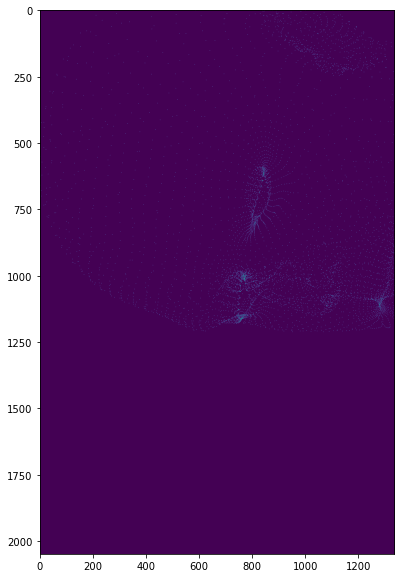

In [80]:
import matplotlib.pyplot as plt
img = np.zeros((h//scale, w//scale))
for point in point_list:
    #print(point)
    if point[0]<h//scale and point[0]>0:
        if point[1]<w//scale and point[1]>0:
            img[int(point[0]),int(point[1])] = 1

plt.figure(figsize=(10,10))
plt.imshow(img)

(2048, 1334, 3) torch.Size([3, 2048, 1334]) (1334, 2048) (128, 83, 3)


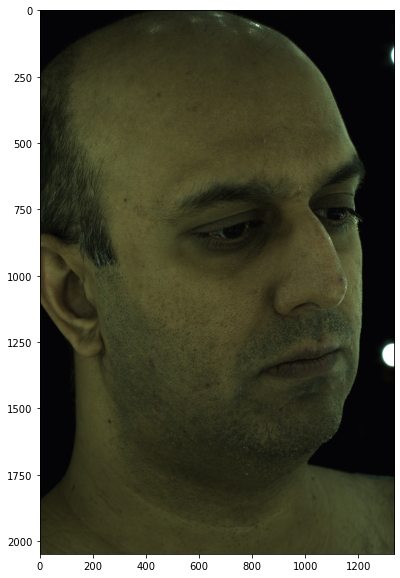

In [39]:
import torch
from torchvision import transforms as T
transform = T.ToTensor()

img_path = base+'/images/E001_Neutral_Eyes_Open/'+cam
img = Image.open(img_path+'/000102.png').convert('RGB')
img = np.array(img)
img_tensor = transform(img)

#img = np.transpose(np.array(img), (1,0,2))
print(img.shape, img_tensor.shape, (w,h), directions.shape)

plt.figure(figsize=(10,10))
plt.imshow(img)

In [15]:
import torch
from torchvision import transforms as T
transform = T.ToTensor()

In [14]:
rays_o+ rays_d * (-1100)

array([[  77.57544444, -158.89237448, 1046.74548575],
       [  75.60706508, -158.83741112, 1047.83735604],
       [  73.6357969 , -158.78310627, 1048.92561286],
       ...,
       [-116.66005348,  119.26453788, 1047.7082317 ],
       [-118.77710197,  119.21914278, 1048.47977985],
       [-120.89485331,  119.17191852, 1049.24708151]])

In [34]:
img_tensor = transform(img)

In [35]:
img_tensor.shape

torch.Size([3, 2048, 1334])

In [27]:
np.transpose(np.array(img), (1,0,2)).shape

(1334, 2048, 3)